In [1]:
%matplotlib inline

In [2]:
import numpy as np
import pandas as pd
from scipy import stats, integrate
import matplotlib.pyplot as plt

In [3]:
import seaborn as sns
import shutil
from sklearn.utils import shuffle

# Importando base de dados

In [4]:
dfm = pd.read_csv('../data/derivaded_3.csv',index_col=0)
print (len(dfm))
dfm = dfm.drop('prcp_plus_12',1)
dfm.head(3)

27721


,prcp,stp,smax,smin,temp,tmax,tmin,dewp,dmax,dmin,...,dmax_16,dmax_17,dmax_18,dmax_19,dmax_20,dmax_21,dmax_22,dmax_23,dmax_24,prcp_acum_24
0,0.0,918.2,918.2,917.5,18.8,17.1,20.2,17.1,18.8,16.2,...,19.9,20.2,20.1,20.2,20.4,20.6,20.5,20.7,20.4,2.0
1,0.4,918.7,918.7,918.2,18.6,17.2,18.9,17.2,18.6,17.1,...,19.9,19.9,20.2,20.1,20.2,20.4,20.6,20.5,20.7,2.0
2,1.0,918.7,918.8,918.7,18.4,17.3,18.6,17.4,18.3,17.2,...,20.6,19.9,19.9,20.2,20.1,20.2,20.4,20.6,20.5,1.6


<h2>Mineiração dos dados</h2>

<h3>Rede neural</h3>

In [5]:
import tensorflow as tf  
from sklearn.metrics import explained_variance_score, mean_absolute_error,  median_absolute_error
from sklearn.model_selection import train_test_split 

In [6]:
target = 'prcp_acum_24'

In [7]:
def f(x):
    if x[target] <= 0.0: 
        return 0
    elif x[target] < 50:       
        return 1
    else:
        return 2     

In [8]:
X = dfm[[col for col in dfm.columns]]

In [9]:
X.loc[:,('rain')] = X.apply(f,axis=1)

In [10]:
X.sample(3)

,prcp,stp,smax,smin,temp,tmax,tmin,dewp,dmax,dmin,...,dmax_17,dmax_18,dmax_19,dmax_20,dmax_21,dmax_22,dmax_23,dmax_24,prcp_acum_24,rain
11699,0.0,913.6,913.7,913.5,19.9,19.3,20.1,19.5,19.7,19.1,...,21.9,21.6,21.0,20.7,20.4,20.4,20.5,20.4,17.2,1
8036,0.0,915.1,915.2,914.9,26.8,19.0,26.8,19.7,24.5,17.4,...,29.5,29.4,29.0,27.5,27.4,26.9,25.3,24.5,0.0,0
2044,0.0,919.2,919.5,919.1,24.8,17.1,26.1,18.1,23.9,16.2,...,25.0,27.6,27.7,27.5,25.4,25.4,23.9,22.6,0.0,0


In [11]:
y = X['prcp_acum_24']
y.sample(3)

6808     0.0
5061     0.0
8454    45.4
Name: prcp_acum_24, dtype: float64

In [12]:
#X.describe()

<h3>Normalization</h3>

In [13]:
col = [c for c in X.columns if c not in ['rain']]

In [14]:
bkp_X = X

In [15]:
from sklearn.preprocessing import MinMaxScaler

scale = MinMaxScaler(feature_range=(-0.8, 0.8))
    
X[col] = scale.fit_transform(X[col])

In [16]:
r = scale.inverse_transform(X[col])
restored = pd.DataFrame(r, index=X[col].index, columns=X[col].columns)

In [17]:
r_X = pd.concat([restored,X['rain']], axis=1)

In [18]:
print (isinstance(r_X, pd.DataFrame))    
print (bkp_X.equals(X))

True
True


<p>Separando o conjunto de treinamento e validação (metade dos 20% separados para validação e testes)</p>

In [19]:
X_train, X_tmp, y_train, y_tmp = train_test_split(X, y, test_size=0.2, random_state=13, stratify = X['rain']) 

<p>Separando o conjunto de testes</p>

In [20]:
X_test, X_val, y_test, y_val = train_test_split(X_tmp, y_tmp, test_size=0.5, random_state=13, stratify = X_tmp['rain'])

In [21]:
X_train.shape, X_test.shape, X_val.shape  
print("Training instances   {}, Training features   {}".format(X_train.shape[0], X_train.shape[1]))  
print("Validation instances {}, Validation features {}".format(X_val.shape[0], X_val.shape[1]))  
print("Testing instances    {}, Testing features    {}".format(X_test.shape[0], X_test.shape[1]))  

Training instances   22176, Training features   327
Validation instances 2773, Validation features 327
Testing instances    2772, Testing features    327


In [22]:
X.groupby('rain').size()

rain
0    14070
1    12294
2     1357
dtype: int64

In [23]:
# Zarate instructions
st_units = (X_train.shape[1] * 2) + 1
sd_units = 3
fn = tf.sigmoid
batch_size = 1000

In [24]:
features = [col for col in X_train.columns if col not in ['rain',target]]
feature_cols = [tf.feature_column.numeric_column(f) for f in features] 

In [25]:
feature_cols

[_NumericColumn(key='prcp', shape=(1,), default_value=None, dtype=tf.float32, normalizer_fn=None),
 _NumericColumn(key='stp', shape=(1,), default_value=None, dtype=tf.float32, normalizer_fn=None),
 _NumericColumn(key='smax', shape=(1,), default_value=None, dtype=tf.float32, normalizer_fn=None),
 _NumericColumn(key='smin', shape=(1,), default_value=None, dtype=tf.float32, normalizer_fn=None),
 _NumericColumn(key='temp', shape=(1,), default_value=None, dtype=tf.float32, normalizer_fn=None),
 _NumericColumn(key='tmax', shape=(1,), default_value=None, dtype=tf.float32, normalizer_fn=None),
 _NumericColumn(key='tmin', shape=(1,), default_value=None, dtype=tf.float32, normalizer_fn=None),
 _NumericColumn(key='dewp', shape=(1,), default_value=None, dtype=tf.float32, normalizer_fn=None),
 _NumericColumn(key='dmax', shape=(1,), default_value=None, dtype=tf.float32, normalizer_fn=None),
 _NumericColumn(key='dmin', shape=(1,), default_value=None, dtype=tf.float32, normalizer_fn=None),
 _NumericCo

In [26]:
regressor = tf.estimator.DNNRegressor(feature_columns=feature_cols
                                      ,hidden_units=[st_units,sd_units]
                                      ,activation_fn=fn
                                      ,model_dir='/tmp/tf_model_17_3')

INFO:tensorflow:Using default config.
INFO:tensorflow:Using config: {'_master': '', '_evaluation_master': '', '_keep_checkpoint_every_n_hours': 10000, '_num_ps_replicas': 0, '_service': None, '_save_summary_steps': 100, '_global_id_in_cluster': 0, '_num_worker_replicas': 1, '_log_step_count_steps': 100, '_model_dir': '/tmp/tf_model_17_3', '_task_id': 0, '_is_chief': True, '_keep_checkpoint_max': 5, '_task_type': 'worker', '_save_checkpoints_secs': 600, '_session_config': None, '_save_checkpoints_steps': None, '_tf_random_seed': None, '_cluster_spec': <tensorflow.python.training.server_lib.ClusterSpec object at 0x7f595ef9d710>}


In [27]:
def wx_input_fn(X, y=None, num_epochs=None, shuffle=True, batch_size=batch_size):      
    return tf.estimator.inputs.pandas_input_fn(x=X,
                                               y=y,
                                               num_epochs=num_epochs,
                                               shuffle=shuffle,
                                               batch_size=batch_size)

In [28]:
from imblearn.under_sampling import RandomUnderSampler
under = RandomUnderSampler(return_indices=True)

In [29]:
def only_freatures(df):
    df = df.drop('rain',1)
    df = df.drop('prcp_acum_24',1)
    return df

In [30]:
def balancear(X, y):

    X_resampled, y_resampled, idx_resampled = under.fit_sample(X, X['rain'])

    X = pd.DataFrame(X_resampled, index=idx_resampled, columns = X.columns)
    y = pd.DataFrame(y_resampled, index=idx_resampled, columns =[target])

    X = only_freatures(X)
    
    return X,y

In [31]:
#A, b = balancear(X_train, y_train)

In [32]:
#print (A.loc[(A.index ==11783)].values.sum())
#print (X_train.loc[(X.index ==11783)].values.sum())

In [33]:
#A.loc[(A.index ==11783)]

In [34]:
#X_train.loc[(X.index ==11783)]

In [35]:
evaluations = []  
STEPS = 500  

for i in range(1, 100):    
    
    print ('balanceando...')
    
    A, b = balancear(X_train, y_train)
    
    print ('treinando agora...')
    
    regressor.train(input_fn=wx_input_fn(A ,b), steps=STEPS)
    
    evaluations.append(
        regressor.evaluate(input_fn=wx_input_fn(only_freatures(X_val)
                                                ,y_val
                                                ,num_epochs=1
                                                ,shuffle=False)))

balanceando...
treinando agora...
INFO:tensorflow:Calling model_fn.
INFO:tensorflow:Done calling model_fn.
INFO:tensorflow:Create CheckpointSaverHook.
INFO:tensorflow:Graph was finalized.
INFO:tensorflow:Running local_init_op.
INFO:tensorflow:Done running local_init_op.
INFO:tensorflow:Saving checkpoints for 1 into /tmp/tf_model_17_3/model.ckpt.
INFO:tensorflow:step = 1, loss = 2381.6924
INFO:tensorflow:global_step/sec: 3.13493
INFO:tensorflow:step = 101, loss = 1238.5876 (31.900 sec)
INFO:tensorflow:global_step/sec: 2.96942
INFO:tensorflow:step = 201, loss = 683.4833 (33.676 sec)
INFO:tensorflow:global_step/sec: 2.90837
INFO:tensorflow:step = 301, loss = 440.49884 (34.383 sec)
INFO:tensorflow:global_step/sec: 2.8781
INFO:tensorflow:step = 401, loss = 844.9045 (34.745 sec)
INFO:tensorflow:Saving checkpoints for 500 into /tmp/tf_model_17_3/model.ckpt.
INFO:tensorflow:Loss for final step: 349.73056.
INFO:tensorflow:Calling model_fn.
INFO:tensorflow:Done calling model_fn.
INFO:tensorflow:

INFO:tensorflow:step = 2901, loss = 899.9658 (33.905 sec)
INFO:tensorflow:Saving checkpoints for 3000 into /tmp/tf_model_17_3/model.ckpt.
INFO:tensorflow:Loss for final step: 507.13855.
INFO:tensorflow:Calling model_fn.
INFO:tensorflow:Done calling model_fn.
INFO:tensorflow:Starting evaluation at 2018-04-20-04:24:51
INFO:tensorflow:Graph was finalized.
INFO:tensorflow:Restoring parameters from /tmp/tf_model_17_3/model.ckpt-3000
INFO:tensorflow:Running local_init_op.
INFO:tensorflow:Done running local_init_op.
INFO:tensorflow:Finished evaluation at 2018-04-20-04:24:53
INFO:tensorflow:Saving dict for global step 3000: average_loss = 2.9673314, global_step = 3000, loss = 2742.8035
balanceando...
treinando agora...
INFO:tensorflow:Calling model_fn.
INFO:tensorflow:Done calling model_fn.
INFO:tensorflow:Create CheckpointSaverHook.
INFO:tensorflow:Graph was finalized.
INFO:tensorflow:Restoring parameters from /tmp/tf_model_17_3/model.ckpt-3000
INFO:tensorflow:Running local_init_op.
INFO:tens

INFO:tensorflow:Calling model_fn.
INFO:tensorflow:Done calling model_fn.
INFO:tensorflow:Create CheckpointSaverHook.
INFO:tensorflow:Graph was finalized.
INFO:tensorflow:Restoring parameters from /tmp/tf_model_17_3/model.ckpt-5500
INFO:tensorflow:Running local_init_op.
INFO:tensorflow:Done running local_init_op.
INFO:tensorflow:Saving checkpoints for 5501 into /tmp/tf_model_17_3/model.ckpt.
INFO:tensorflow:step = 5501, loss = 273.0097
INFO:tensorflow:global_step/sec: 2.96254
INFO:tensorflow:step = 5601, loss = 808.9898 (33.756 sec)
INFO:tensorflow:global_step/sec: 3.012
INFO:tensorflow:step = 5701, loss = 887.4375 (33.201 sec)
INFO:tensorflow:global_step/sec: 3.00333
INFO:tensorflow:step = 5801, loss = 516.8439 (33.296 sec)
INFO:tensorflow:global_step/sec: 3.05411
INFO:tensorflow:step = 5901, loss = 498.43457 (32.743 sec)
INFO:tensorflow:Saving checkpoints for 6000 into /tmp/tf_model_17_3/model.ckpt.
INFO:tensorflow:Loss for final step: 729.8547.
INFO:tensorflow:Calling model_fn.
INFO:

INFO:tensorflow:global_step/sec: 3.1906
INFO:tensorflow:step = 8401, loss = 918.99493 (31.343 sec)
INFO:tensorflow:Saving checkpoints for 8500 into /tmp/tf_model_17_3/model.ckpt.
INFO:tensorflow:Loss for final step: 445.77692.
INFO:tensorflow:Calling model_fn.
INFO:tensorflow:Done calling model_fn.
INFO:tensorflow:Starting evaluation at 2018-04-20-04:57:09
INFO:tensorflow:Graph was finalized.
INFO:tensorflow:Restoring parameters from /tmp/tf_model_17_3/model.ckpt-8500
INFO:tensorflow:Running local_init_op.
INFO:tensorflow:Done running local_init_op.
INFO:tensorflow:Finished evaluation at 2018-04-20-04:57:11
INFO:tensorflow:Saving dict for global step 8500: average_loss = 2.9664955, global_step = 8500, loss = 2742.0305
balanceando...
treinando agora...
INFO:tensorflow:Calling model_fn.
INFO:tensorflow:Done calling model_fn.
INFO:tensorflow:Create CheckpointSaverHook.
INFO:tensorflow:Graph was finalized.
INFO:tensorflow:Restoring parameters from /tmp/tf_model_17_3/model.ckpt-8500
INFO:te

balanceando...
treinando agora...
INFO:tensorflow:Calling model_fn.
INFO:tensorflow:Done calling model_fn.
INFO:tensorflow:Create CheckpointSaverHook.
INFO:tensorflow:Graph was finalized.
INFO:tensorflow:Restoring parameters from /tmp/tf_model_17_3/model.ckpt-11000
INFO:tensorflow:Running local_init_op.
INFO:tensorflow:Done running local_init_op.
INFO:tensorflow:Saving checkpoints for 11001 into /tmp/tf_model_17_3/model.ckpt.
INFO:tensorflow:step = 11001, loss = 922.86743
INFO:tensorflow:global_step/sec: 2.95518
INFO:tensorflow:step = 11101, loss = 799.811 (33.840 sec)
INFO:tensorflow:global_step/sec: 3.03725
INFO:tensorflow:step = 11201, loss = 323.14877 (32.925 sec)
INFO:tensorflow:global_step/sec: 3.03151
INFO:tensorflow:step = 11301, loss = 694.87354 (32.987 sec)
INFO:tensorflow:global_step/sec: 3.03615
INFO:tensorflow:step = 11401, loss = 912.013 (32.937 sec)
INFO:tensorflow:Saving checkpoints for 11500 into /tmp/tf_model_17_3/model.ckpt.
INFO:tensorflow:Loss for final step: 462.8

INFO:tensorflow:global_step/sec: 3.11582
INFO:tensorflow:step = 13801, loss = 830.487 (32.094 sec)
INFO:tensorflow:global_step/sec: 3.06185
INFO:tensorflow:step = 13901, loss = 863.98663 (32.660 sec)
INFO:tensorflow:Saving checkpoints for 14000 into /tmp/tf_model_17_3/model.ckpt.
INFO:tensorflow:Loss for final step: 658.39685.
INFO:tensorflow:Calling model_fn.
INFO:tensorflow:Done calling model_fn.
INFO:tensorflow:Starting evaluation at 2018-04-20-05:28:48
INFO:tensorflow:Graph was finalized.
INFO:tensorflow:Restoring parameters from /tmp/tf_model_17_3/model.ckpt-14000
INFO:tensorflow:Running local_init_op.
INFO:tensorflow:Done running local_init_op.
INFO:tensorflow:Finished evaluation at 2018-04-20-05:28:50
INFO:tensorflow:Saving dict for global step 14000: average_loss = 2.9689205, global_step = 14000, loss = 2744.2722
balanceando...
treinando agora...
INFO:tensorflow:Calling model_fn.
INFO:tensorflow:Done calling model_fn.
INFO:tensorflow:Create CheckpointSaverHook.
INFO:tensorflow:

INFO:tensorflow:Finished evaluation at 2018-04-20-05:43:14
INFO:tensorflow:Saving dict for global step 16500: average_loss = 2.969666, global_step = 16500, loss = 2744.9612
balanceando...
treinando agora...
INFO:tensorflow:Calling model_fn.
INFO:tensorflow:Done calling model_fn.
INFO:tensorflow:Create CheckpointSaverHook.
INFO:tensorflow:Graph was finalized.
INFO:tensorflow:Restoring parameters from /tmp/tf_model_17_3/model.ckpt-16500
INFO:tensorflow:Running local_init_op.
INFO:tensorflow:Done running local_init_op.
INFO:tensorflow:Saving checkpoints for 16501 into /tmp/tf_model_17_3/model.ckpt.
INFO:tensorflow:step = 16501, loss = 914.9197
INFO:tensorflow:global_step/sec: 3.14145
INFO:tensorflow:step = 16601, loss = 337.97058 (31.834 sec)
INFO:tensorflow:global_step/sec: 3.18234
INFO:tensorflow:step = 16701, loss = 665.57135 (31.423 sec)
INFO:tensorflow:global_step/sec: 3.21619
INFO:tensorflow:step = 16801, loss = 911.9901 (31.093 sec)
INFO:tensorflow:global_step/sec: 3.14597
INFO:ten

INFO:tensorflow:global_step/sec: 3.01943
INFO:tensorflow:step = 19101, loss = 432.2681 (33.119 sec)
INFO:tensorflow:global_step/sec: 3.05718
INFO:tensorflow:step = 19201, loss = 834.87585 (32.710 sec)
INFO:tensorflow:global_step/sec: 3.1112
INFO:tensorflow:step = 19301, loss = 877.56433 (32.142 sec)
INFO:tensorflow:global_step/sec: 3.09719
INFO:tensorflow:step = 19401, loss = 403.90207 (32.287 sec)
INFO:tensorflow:Saving checkpoints for 19500 into /tmp/tf_model_17_3/model.ckpt.
INFO:tensorflow:Loss for final step: 920.0355.
INFO:tensorflow:Calling model_fn.
INFO:tensorflow:Done calling model_fn.
INFO:tensorflow:Starting evaluation at 2018-04-20-06:00:24
INFO:tensorflow:Graph was finalized.
INFO:tensorflow:Restoring parameters from /tmp/tf_model_17_3/model.ckpt-19500
INFO:tensorflow:Running local_init_op.
INFO:tensorflow:Done running local_init_op.
INFO:tensorflow:Finished evaluation at 2018-04-20-06:00:27
INFO:tensorflow:Saving dict for global step 19500: average_loss = 2.9715245, glob

INFO:tensorflow:Graph was finalized.
INFO:tensorflow:Restoring parameters from /tmp/tf_model_17_3/model.ckpt-22000
INFO:tensorflow:Running local_init_op.
INFO:tensorflow:Done running local_init_op.
INFO:tensorflow:Finished evaluation at 2018-04-20-06:14:51
INFO:tensorflow:Saving dict for global step 22000: average_loss = 2.9674487, global_step = 22000, loss = 2742.9119
balanceando...
treinando agora...
INFO:tensorflow:Calling model_fn.
INFO:tensorflow:Done calling model_fn.
INFO:tensorflow:Create CheckpointSaverHook.
INFO:tensorflow:Graph was finalized.
INFO:tensorflow:Restoring parameters from /tmp/tf_model_17_3/model.ckpt-22000
INFO:tensorflow:Running local_init_op.
INFO:tensorflow:Done running local_init_op.
INFO:tensorflow:Saving checkpoints for 22001 into /tmp/tf_model_17_3/model.ckpt.
INFO:tensorflow:step = 22001, loss = 307.3589
INFO:tensorflow:global_step/sec: 3.14523
INFO:tensorflow:step = 22101, loss = 560.92236 (31.796 sec)
INFO:tensorflow:global_step/sec: 3.19268
INFO:tenso

INFO:tensorflow:Done running local_init_op.
INFO:tensorflow:Saving checkpoints for 24501 into /tmp/tf_model_17_3/model.ckpt.
INFO:tensorflow:step = 24501, loss = 919.7549
INFO:tensorflow:global_step/sec: 2.93777
INFO:tensorflow:step = 24601, loss = 790.734 (34.041 sec)
INFO:tensorflow:global_step/sec: 3.10692
INFO:tensorflow:step = 24701, loss = 322.1169 (32.186 sec)
INFO:tensorflow:global_step/sec: 3.13946
INFO:tensorflow:step = 24801, loss = 680.6935 (31.853 sec)
INFO:tensorflow:global_step/sec: 3.06537
INFO:tensorflow:step = 24901, loss = 918.0139 (32.623 sec)
INFO:tensorflow:Saving checkpoints for 25000 into /tmp/tf_model_17_3/model.ckpt.
INFO:tensorflow:Loss for final step: 469.8039.
INFO:tensorflow:Calling model_fn.
INFO:tensorflow:Done calling model_fn.
INFO:tensorflow:Starting evaluation at 2018-04-20-06:32:07
INFO:tensorflow:Graph was finalized.
INFO:tensorflow:Restoring parameters from /tmp/tf_model_17_3/model.ckpt-25000
INFO:tensorflow:Running local_init_op.
INFO:tensorflow:

INFO:tensorflow:Loss for final step: 881.9418.
INFO:tensorflow:Calling model_fn.
INFO:tensorflow:Done calling model_fn.
INFO:tensorflow:Starting evaluation at 2018-04-20-06:46:26
INFO:tensorflow:Graph was finalized.
INFO:tensorflow:Restoring parameters from /tmp/tf_model_17_3/model.ckpt-27500
INFO:tensorflow:Running local_init_op.
INFO:tensorflow:Done running local_init_op.
INFO:tensorflow:Finished evaluation at 2018-04-20-06:46:28
INFO:tensorflow:Saving dict for global step 27500: average_loss = 2.9683084, global_step = 27500, loss = 2743.7063
balanceando...
treinando agora...
INFO:tensorflow:Calling model_fn.
INFO:tensorflow:Done calling model_fn.
INFO:tensorflow:Create CheckpointSaverHook.
INFO:tensorflow:Graph was finalized.
INFO:tensorflow:Restoring parameters from /tmp/tf_model_17_3/model.ckpt-27500
INFO:tensorflow:Running local_init_op.
INFO:tensorflow:Done running local_init_op.
INFO:tensorflow:Saving checkpoints for 27501 into /tmp/tf_model_17_3/model.ckpt.
INFO:tensorflow:ste

INFO:tensorflow:Create CheckpointSaverHook.
INFO:tensorflow:Graph was finalized.
INFO:tensorflow:Restoring parameters from /tmp/tf_model_17_3/model.ckpt-30000
INFO:tensorflow:Running local_init_op.
INFO:tensorflow:Done running local_init_op.
INFO:tensorflow:Saving checkpoints for 30001 into /tmp/tf_model_17_3/model.ckpt.
INFO:tensorflow:step = 30001, loss = 999.9558
INFO:tensorflow:global_step/sec: 3.15484
INFO:tensorflow:step = 30101, loss = 421.973 (31.699 sec)
INFO:tensorflow:global_step/sec: 3.19142
INFO:tensorflow:step = 30201, loss = 559.2908 (31.334 sec)
INFO:tensorflow:global_step/sec: 3.16173
INFO:tensorflow:step = 30301, loss = 879.0887 (31.628 sec)
INFO:tensorflow:global_step/sec: 3.20552
INFO:tensorflow:step = 30401, loss = 711.96155 (31.196 sec)
INFO:tensorflow:Saving checkpoints for 30500 into /tmp/tf_model_17_3/model.ckpt.
INFO:tensorflow:Loss for final step: 824.4913.
INFO:tensorflow:Calling model_fn.
INFO:tensorflow:Done calling model_fn.
INFO:tensorflow:Starting evalu

INFO:tensorflow:global_step/sec: 3.15266
INFO:tensorflow:step = 32901, loss = 711.8364 (31.730 sec)
INFO:tensorflow:Saving checkpoints for 33000 into /tmp/tf_model_17_3/model.ckpt.
INFO:tensorflow:Loss for final step: 831.61597.
INFO:tensorflow:Calling model_fn.
INFO:tensorflow:Done calling model_fn.
INFO:tensorflow:Starting evaluation at 2018-04-20-07:17:53
INFO:tensorflow:Graph was finalized.
INFO:tensorflow:Restoring parameters from /tmp/tf_model_17_3/model.ckpt-33000
INFO:tensorflow:Running local_init_op.
INFO:tensorflow:Done running local_init_op.
INFO:tensorflow:Finished evaluation at 2018-04-20-07:17:55
INFO:tensorflow:Saving dict for global step 33000: average_loss = 2.9702165, global_step = 33000, loss = 2745.47
balanceando...
treinando agora...
INFO:tensorflow:Calling model_fn.
INFO:tensorflow:Done calling model_fn.
INFO:tensorflow:Create CheckpointSaverHook.
INFO:tensorflow:Graph was finalized.
INFO:tensorflow:Restoring parameters from /tmp/tf_model_17_3/model.ckpt-33000
INF

balanceando...
treinando agora...
INFO:tensorflow:Calling model_fn.
INFO:tensorflow:Done calling model_fn.
INFO:tensorflow:Create CheckpointSaverHook.
INFO:tensorflow:Graph was finalized.
INFO:tensorflow:Restoring parameters from /tmp/tf_model_17_3/model.ckpt-35500
INFO:tensorflow:Running local_init_op.
INFO:tensorflow:Done running local_init_op.
INFO:tensorflow:Saving checkpoints for 35501 into /tmp/tf_model_17_3/model.ckpt.
INFO:tensorflow:step = 35501, loss = 999.6124
INFO:tensorflow:global_step/sec: 3.15643
INFO:tensorflow:step = 35601, loss = 470.82758 (31.683 sec)
INFO:tensorflow:global_step/sec: 3.22863
INFO:tensorflow:step = 35701, loss = 517.35956 (30.973 sec)
INFO:tensorflow:global_step/sec: 3.22115
INFO:tensorflow:step = 35801, loss = 895.2464 (31.045 sec)
INFO:tensorflow:global_step/sec: 3.17478
INFO:tensorflow:step = 35901, loss = 744.7804 (31.498 sec)
INFO:tensorflow:Saving checkpoints for 36000 into /tmp/tf_model_17_3/model.ckpt.
INFO:tensorflow:Loss for final step: 808.

INFO:tensorflow:global_step/sec: 3.16197
INFO:tensorflow:step = 38301, loss = 331.0155 (31.626 sec)
INFO:tensorflow:global_step/sec: 3.12025
INFO:tensorflow:step = 38401, loss = 774.7143 (32.049 sec)
INFO:tensorflow:Saving checkpoints for 38500 into /tmp/tf_model_17_3/model.ckpt.
INFO:tensorflow:Loss for final step: 501.80832.
INFO:tensorflow:Calling model_fn.
INFO:tensorflow:Done calling model_fn.
INFO:tensorflow:Starting evaluation at 2018-04-20-07:49:16
INFO:tensorflow:Graph was finalized.
INFO:tensorflow:Restoring parameters from /tmp/tf_model_17_3/model.ckpt-38500
INFO:tensorflow:Running local_init_op.
INFO:tensorflow:Done running local_init_op.
INFO:tensorflow:Finished evaluation at 2018-04-20-07:49:18
INFO:tensorflow:Saving dict for global step 38500: average_loss = 2.9712663, global_step = 38500, loss = 2746.4404
balanceando...
treinando agora...
INFO:tensorflow:Calling model_fn.
INFO:tensorflow:Done calling model_fn.
INFO:tensorflow:Create CheckpointSaverHook.
INFO:tensorflow:

INFO:tensorflow:Finished evaluation at 2018-04-20-08:03:42
INFO:tensorflow:Saving dict for global step 41000: average_loss = 2.9720027, global_step = 41000, loss = 2747.121
balanceando...
treinando agora...
INFO:tensorflow:Calling model_fn.
INFO:tensorflow:Done calling model_fn.
INFO:tensorflow:Create CheckpointSaverHook.
INFO:tensorflow:Graph was finalized.
INFO:tensorflow:Restoring parameters from /tmp/tf_model_17_3/model.ckpt-41000
INFO:tensorflow:Running local_init_op.
INFO:tensorflow:Done running local_init_op.
INFO:tensorflow:Saving checkpoints for 41001 into /tmp/tf_model_17_3/model.ckpt.
INFO:tensorflow:step = 41001, loss = 932.3928
INFO:tensorflow:global_step/sec: 3.02315
INFO:tensorflow:step = 41101, loss = 744.6863 (33.079 sec)
INFO:tensorflow:global_step/sec: 3.06903
INFO:tensorflow:step = 41201, loss = 330.9852 (32.584 sec)
INFO:tensorflow:global_step/sec: 3.07522
INFO:tensorflow:step = 41301, loss = 754.7023 (32.518 sec)
INFO:tensorflow:global_step/sec: 3.06485
INFO:tenso

INFO:tensorflow:global_step/sec: 3.01698
INFO:tensorflow:step = 43601, loss = 830.0552 (33.147 sec)
INFO:tensorflow:global_step/sec: 3.05032
INFO:tensorflow:step = 43701, loss = 331.19196 (32.784 sec)
INFO:tensorflow:global_step/sec: 3.07698
INFO:tensorflow:step = 43801, loss = 653.36115 (32.498 sec)
INFO:tensorflow:global_step/sec: 3.09888
INFO:tensorflow:step = 43901, loss = 913.96313 (32.271 sec)
INFO:tensorflow:Saving checkpoints for 44000 into /tmp/tf_model_17_3/model.ckpt.
INFO:tensorflow:Loss for final step: 445.68756.
INFO:tensorflow:Calling model_fn.
INFO:tensorflow:Done calling model_fn.
INFO:tensorflow:Starting evaluation at 2018-04-20-08:21:08
INFO:tensorflow:Graph was finalized.
INFO:tensorflow:Restoring parameters from /tmp/tf_model_17_3/model.ckpt-44000
INFO:tensorflow:Running local_init_op.
INFO:tensorflow:Done running local_init_op.
INFO:tensorflow:Finished evaluation at 2018-04-20-08:21:10
INFO:tensorflow:Saving dict for global step 44000: average_loss = 2.9663694, gl

INFO:tensorflow:Graph was finalized.
INFO:tensorflow:Restoring parameters from /tmp/tf_model_17_3/model.ckpt-46500
INFO:tensorflow:Running local_init_op.
INFO:tensorflow:Done running local_init_op.
INFO:tensorflow:Finished evaluation at 2018-04-20-08:35:23
INFO:tensorflow:Saving dict for global step 46500: average_loss = 2.969898, global_step = 46500, loss = 2745.1758
balanceando...
treinando agora...
INFO:tensorflow:Calling model_fn.
INFO:tensorflow:Done calling model_fn.
INFO:tensorflow:Create CheckpointSaverHook.
INFO:tensorflow:Graph was finalized.
INFO:tensorflow:Restoring parameters from /tmp/tf_model_17_3/model.ckpt-46500
INFO:tensorflow:Running local_init_op.
INFO:tensorflow:Done running local_init_op.
INFO:tensorflow:Saving checkpoints for 46501 into /tmp/tf_model_17_3/model.ckpt.
INFO:tensorflow:step = 46501, loss = 582.86426
INFO:tensorflow:global_step/sec: 3.07794
INFO:tensorflow:step = 46601, loss = 436.09857 (32.491 sec)
INFO:tensorflow:global_step/sec: 3.15415
INFO:tenso

INFO:tensorflow:Done running local_init_op.
INFO:tensorflow:Saving checkpoints for 49001 into /tmp/tf_model_17_3/model.ckpt.
INFO:tensorflow:step = 49001, loss = 218.86128
INFO:tensorflow:global_step/sec: 3.11287
INFO:tensorflow:step = 49101, loss = 775.2357 (32.126 sec)
INFO:tensorflow:global_step/sec: 3.18709
INFO:tensorflow:step = 49201, loss = 906.6384 (31.376 sec)
INFO:tensorflow:global_step/sec: 3.17551
INFO:tensorflow:step = 49301, loss = 541.52515 (31.491 sec)
INFO:tensorflow:global_step/sec: 3.14208
INFO:tensorflow:step = 49401, loss = 457.3711 (31.826 sec)
INFO:tensorflow:Saving checkpoints for 49500 into /tmp/tf_model_17_3/model.ckpt.
INFO:tensorflow:Loss for final step: 773.4501.
INFO:tensorflow:Calling model_fn.
INFO:tensorflow:Done calling model_fn.
INFO:tensorflow:Starting evaluation at 2018-04-20-08:52:23
INFO:tensorflow:Graph was finalized.
INFO:tensorflow:Restoring parameters from /tmp/tf_model_17_3/model.ckpt-49500
INFO:tensorflow:Running local_init_op.
INFO:tensorfl

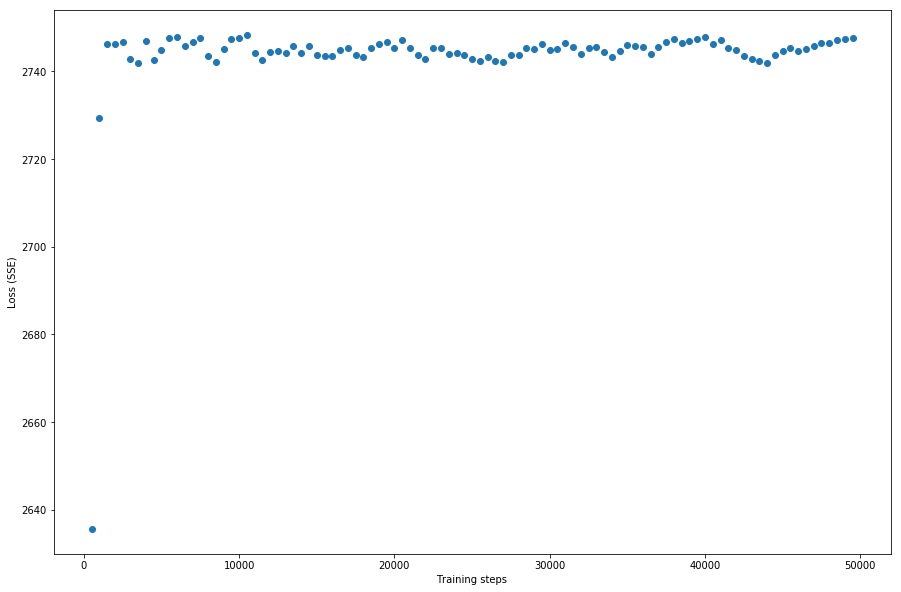

In [36]:
import matplotlib.pyplot as plt  
%matplotlib inline

plt.rcParams['figure.figsize'] = [15, 10]

loss_values = [ev['loss'] for ev in evaluations]  
training_steps = [ev['global_step'] for ev in evaluations]

plt.scatter(x=training_steps, y=loss_values)  
plt.xlabel('Training steps')  
plt.ylabel('Loss (SSE)')  
plt.show()  

In [37]:
pred = regressor.predict(input_fn=wx_input_fn(only_freatures(X_test),  
                                              num_epochs=1,
                                              shuffle=False))

predictions = np.array([p['predictions'][0] for p in pred])

INFO:tensorflow:Calling model_fn.
INFO:tensorflow:Done calling model_fn.
INFO:tensorflow:Graph was finalized.
INFO:tensorflow:Restoring parameters from /tmp/tf_model_17_3/model.ckpt-49500
INFO:tensorflow:Running local_init_op.
INFO:tensorflow:Done running local_init_op.


In [38]:
predictions

array([1.0008928, 1.0008928, 1.0008928, ..., 1.0008928, 1.0008928,
       1.0008928], dtype=float32)

In [39]:

print("The Explained Variance: %.2f" % explained_variance_score(  
                                            y_test, predictions))  
print("The Mean Absolute Error: %.2f " % mean_absolute_error(  
                                            y_test, predictions))  
print("The Median Absolute Error: %.2f " % median_absolute_error(  
                                            y_test, predictions))

The Explained Variance: 0.00
The Mean Absolute Error: 1.71 
The Median Absolute Error: 1.80 


In [40]:
predictions

array([1.0008928, 1.0008928, 1.0008928, ..., 1.0008928, 1.0008928,
       1.0008928], dtype=float32)

In [41]:
predictions.size

2772

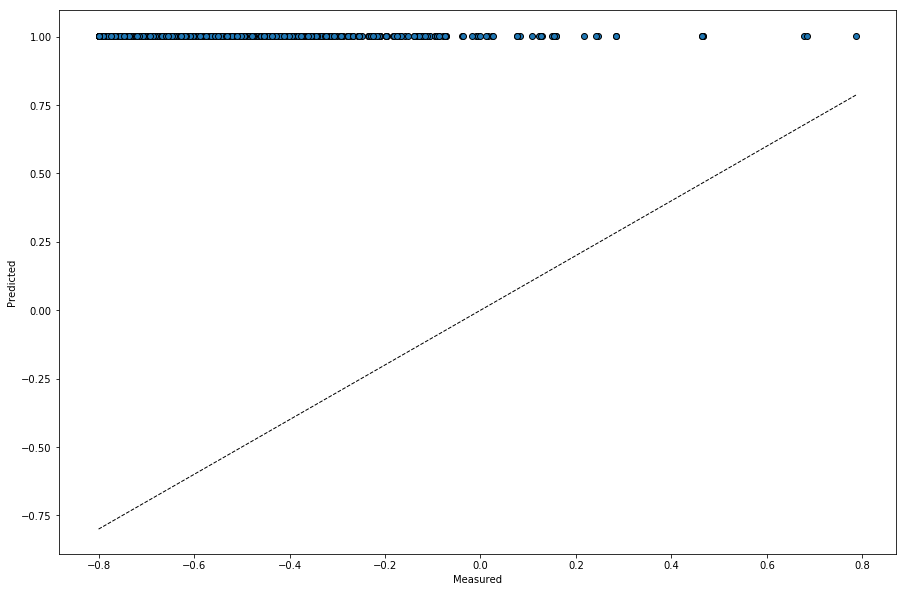

In [42]:
fig, ax = plt.subplots()
ax.scatter(y_test, predictions, edgecolors=(0, 0, 0))
ax.plot([y_test.min(), y_test.max()], [y_test.min(), y_test.max()], 'k--', lw=1)
ax.set_xlabel('Measured')
ax.set_ylabel('Predicted')
plt.show()